In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC32_emimTf2N_PR import configuration
data = pd.read_csv('R32_emimTf2N.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

# Constant
# m.fs.properties.PR_kappa_A['emimTf2N', 'R32'].fix(-0.02489)
# m.fs.properties.PR_kappa_A['R32', 'emimTf2N'].fix(-0.01421)
# m.fs.properties.PR_kappa_B['emimTf2N', 'R32'].fix(0.0)
# m.fs.properties.PR_kappa_B['R32', 'emimTf2N'].fix(0.0)

# Linear
m.fs.properties.PR_kappa_A['emimTf2N', 'R32'].fix(0.26222)
m.fs.properties.PR_kappa_A['R32', 'emimTf2N'].fix(0.07891)
m.fs.properties.PR_kappa_B['emimTf2N', 'R32'].fix(-0.40304)
m.fs.properties.PR_kappa_B['R32', 'emimTf2N'].fix(-0.11806)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))



In [4]:
bmim = np.linspace(data["x_emimTf2N"].iloc[6], data["x_emimTf2N"].iloc[0], 5)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R32_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
    b = 1-(bmim[i])
    P0[i] = 560091.51*b**2 + 647229.15*b + 724.74
    
    m.fs.F101.inlet.temperature.fix(283.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(283.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x1[i] = "NaN"
            P[i] = "NaN"

bmim2 = np.linspace(data["x_emimTf2N"].iloc[14], data["x_emimTf2N"].iloc[7], 5)

P2 = np.zeros((len(bmim2)))
P02 = np.zeros((len(bmim2)))
R32_x2 = np.zeros((len(bmim2)))

for i in range(len(bmim2)-1):
    print(i)
    m.fs.liq = bmim2[i]
    a = bmim2[i]
    b = 1-(bmim2[i])
    P02[i] = 1031357.93*b**2 + 887062.42*b + 3589.01
    
    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P02[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim2[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim2[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P02[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x2[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P2[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x2[i] = "NaN"
            P2[i] = "NaN"
            
bmim3 = np.linspace(data["x_emimTf2N"].iloc[22], data["x_emimTf2N"].iloc[15], 5)

P3 = np.zeros((len(bmim3)))
P03 = np.zeros((len(bmim3)))
R32_x3 = np.zeros((len(bmim3)))

for i in range(len(bmim3)-1):
    print(i)
    m.fs.liq = bmim3[i]
    a = bmim3[i]
    b = 1-(bmim3[i])
    P03[i] = 2386696.58*b - 43057.42
    
    m.fs.F101.inlet.temperature.fix(323.001)
    m.fs.F101.inlet.pressure.fix(P03[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim3[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim3[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(323.001)
    m.fs.F101.vap_outlet.pressure.fix(P03[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x3[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P3[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x3[i] = "NaN"
            P3[i] = "NaN"
            
bmim4 = np.linspace(data["x_emimTf2N"].iloc[30], data["x_emimTf2N"].iloc[24], 5)

P4 = np.zeros((len(bmim4)))
P04 = np.zeros((len(bmim4)))
R32_x4 = np.zeros((len(bmim4)))

for i in range(len(bmim4)-1):
    print(i)
    m.fs.liq = bmim4[i]
    a = bmim4[i]
    b = 1-(bmim4[i])
    P04[i] = 3431386.37*b - 25382.68
    
    m.fs.F101.inlet.temperature.fix(348.001)
    m.fs.F101.inlet.pressure.fix(P04[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim4[i]-0.1))
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(bmim4[i]-0.1)
    m.fs.F101.vap_outlet.temperature.fix(348.001)
    m.fs.F101.vap_outlet.pressure.fix(P04[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x4[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P4[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x4[i] = "NaN"
            P4[i] = "NaN"

0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


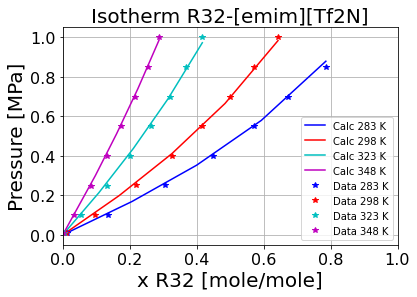

In [5]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

P22= np.zeros((len(P2)))

for i in range(len(P22)):
    P22[i] = P2[i]/1e6    
    
P32= np.zeros((len(P3)))

for i in range(len(P32)):
    P32[i] = P3[i]/1e6

P42= np.zeros((len(P4)))

for i in range(len(P42)):
    P42[i] = P4[i]/1e6
    
plt.plot(R32_x1,P1,"b",label="Calc 283 K")  
plt.plot(R32_x2,P22,"r",label="Calc 298 K") 
plt.plot(R32_x3,P32,"c",label="Calc 323 K") 
plt.plot(R32_x4,P42,"m",label="Calc 348 K")
plt.plot(data["x_R32"][0:7],data["pressure"][0:7]/1e6,"*",color='b',label="Data 283 K")  
plt.plot(data["x_R32"][7:15],data["pressure"][7:15]/1e6,"*",color='r',label="Data 298 K") 
plt.plot(data["x_R32"][15:23],data["pressure"][15:23]/1e6,"*",color='c',label="Data 323 K") 
plt.plot(data["x_R32"][23:],data["pressure"][23:]/1e6,"*",color='m',label="Data 348 K") 
plt.title('Isotherm R32-[emim][Tf2N]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R32 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.ylim(0,1.5)
plt.xlim(0,1.0)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R32-[bmim][PF6]_bin.png', bbox_inches='tight',dpi=300)
plt.show()

In [6]:
df = pd.DataFrame({"P1":P1,"x1":R32_x1,"P2":P22,"x2":R32_x2,"P3":P32,"x3":R32_x3,"P4":P42,"x4":R32_x4})
df.to_csv('P_M2_32_emimTF2N.csv')